# 2D Method Tutorial
**A practical guide for implementing the 2D method to account for Doppler shifts of wave frequency for observations from autonomous surface vehicles.** 

For any question, please contact Luke Colosi at lcolosi@ucsd.edu. 

##  Prerequistes for running this on your own computer 

In order to run this jupyter notebook, you need to have completed the following: 
1. Cloned the WaveSpectrum repository on Github to your local computer following the steps outlined in the README.md documentation. 
2. Installed the MATLAB integration for jupyter (instructions found [here](https://github.com/mathworks/jupyter-matlab-proxy)).

## Overview
In this tutorial, we will cover how to account for Doppler shifts of wave frequencies observed from autonomous surface vehicles. The procedure follows the 2D method discussed in [Colosi et al. (2023)](https://doi.org/10.1175/JTECH-D-23-0022.1). Here, we take estimates of the observed 2D wave spectrum $S_{ob}(f_{ob},\theta)$ measured onboard [Wave Gliders](https://airsea.ucsd.edu/instrumentation/waveglider/) and show how to map the spectrum into intrinsic frequency space (i.e., a reference frame independent of platform motion) and obtain the intrinisic 2D wave spectrum $S_{in}(f_{in},\theta)$. The data set used here consist of a time series of observed 2D wave spectra from the STOKES wave glider deployed during the SMODE pilot program. The 2D spectra are computed every 10 minutes. For more information, see section 2a in Colosi et al. (2023).       

## Here we go...
First, let's change our working directory to the WaveSpectrum repository: 

In [1]:
cd '~/Desktop/projects/asi_lab_summer_internship/WaveSpectrum/'

Next, let's load in the data required for the mapping

In [2]:
load('data/DELMAR2020/STOKES/2D_method_tutorial_data.mat');

Now, let's check what data we are working with: 

In [3]:
who


Your variables are:

S_fob    U_bar    f_cut    f_ob     theta_r  time     



Here is a description of the variables: 

1. `S_fob`: The observed 2D spectrum $S_{ob}(f_{ob},\theta)$ as a function of time. Dimensions: $[N_{freq},N_{theta},N_{time}]$ and units: $\textrm{m}^2 \;(\textrm{Hz} \cdot \textrm{deg})^{-1}$. 

2. `U_bar`: The propagation speed of the observer $\overline{U}$. Dimension: Dimensions: $[1,N_{time}]$ and units: $\textrm{ms}^{-1}$. $\overline{U}$ is computed by time averaging (over $T = 10$ minute intervals) the speed of the platform projected onto the mean platform heading: 

$$ \overline{U} = \frac{1}{T} \sum_{i=0}^{T} U \cos(\phi - \overline{\phi})$$

3. `f_cut`: The noise cutoff frequency for the autonomous surface vehicle. This is the high wave frequency observed by the ASV and depends on the ASV's frequency response and the sampling rate of the instrument. Dimensions: [1,1] and units: $\textrm{Hz}$. 

4. `f_ob`: Observed frequency $f_{ob}$. Dimensions: $[1,N_{freq}]$ and units: $\textrm{Hz}$. 

5. `theta_r`: Angle $\theta_r$ between the propagation velocity of the ASV and the direction of propagation of waves. Dimensions: $[N_{theta},N_{time}]$ and units: $\textrm{deg}$. $\theta_r$ is computed taking the difference between each wave direction and the mean platform heading: 

$$ \theta_r = \theta - \overline{\phi}$$

6. `time`: Time vector. Dimension: $[1,N_{time}]$ and units: datenum.

Note: $N_{theta}$, $N_{freq}$, and $N_{time}$ are the number of angles, frequencies, and time steps respectively. 

Next, for each time step, we will map $S_{ob}(f_{ob},\theta)$ into intrinsic frequency space and obtain $S_{in}(f_{in},\theta)$

In [4]:
% Loop through time
for i = 1:length(time)
    
     % Map the 2D spectrum into intrinsic frequency space 
    [S_fin(:,:,i), f_in(:,:,i), ~] = map_dir_spectrum(S_fob(:,:,i), f_ob, f_cut, U_bar(i), theta_r(:,i));

end

Lastly, let's compute the observed and intrinsic 1D spectra by integrating over all wave directions $\theta$. 

$$ S_{ob}(f_{ob}) = \int_{0}^{2\pi} S_{ob}(f_{ob},\theta) \mathrm{d}\theta $$

In [5]:
% Compute theta differential
dtheta = 360/size(S_fob,2); 

% Compute 1D spectra
S_fob_1d = squeeze(sum(S_fob * dtheta, 2));
S_fin_1d = squeeze(sum(S_fin * dtheta, 2));

Now, let's visualize what's happening here. Let's begin by looking some of the input to the function, namely `U_bar` and `theta_r` as a function of time. 

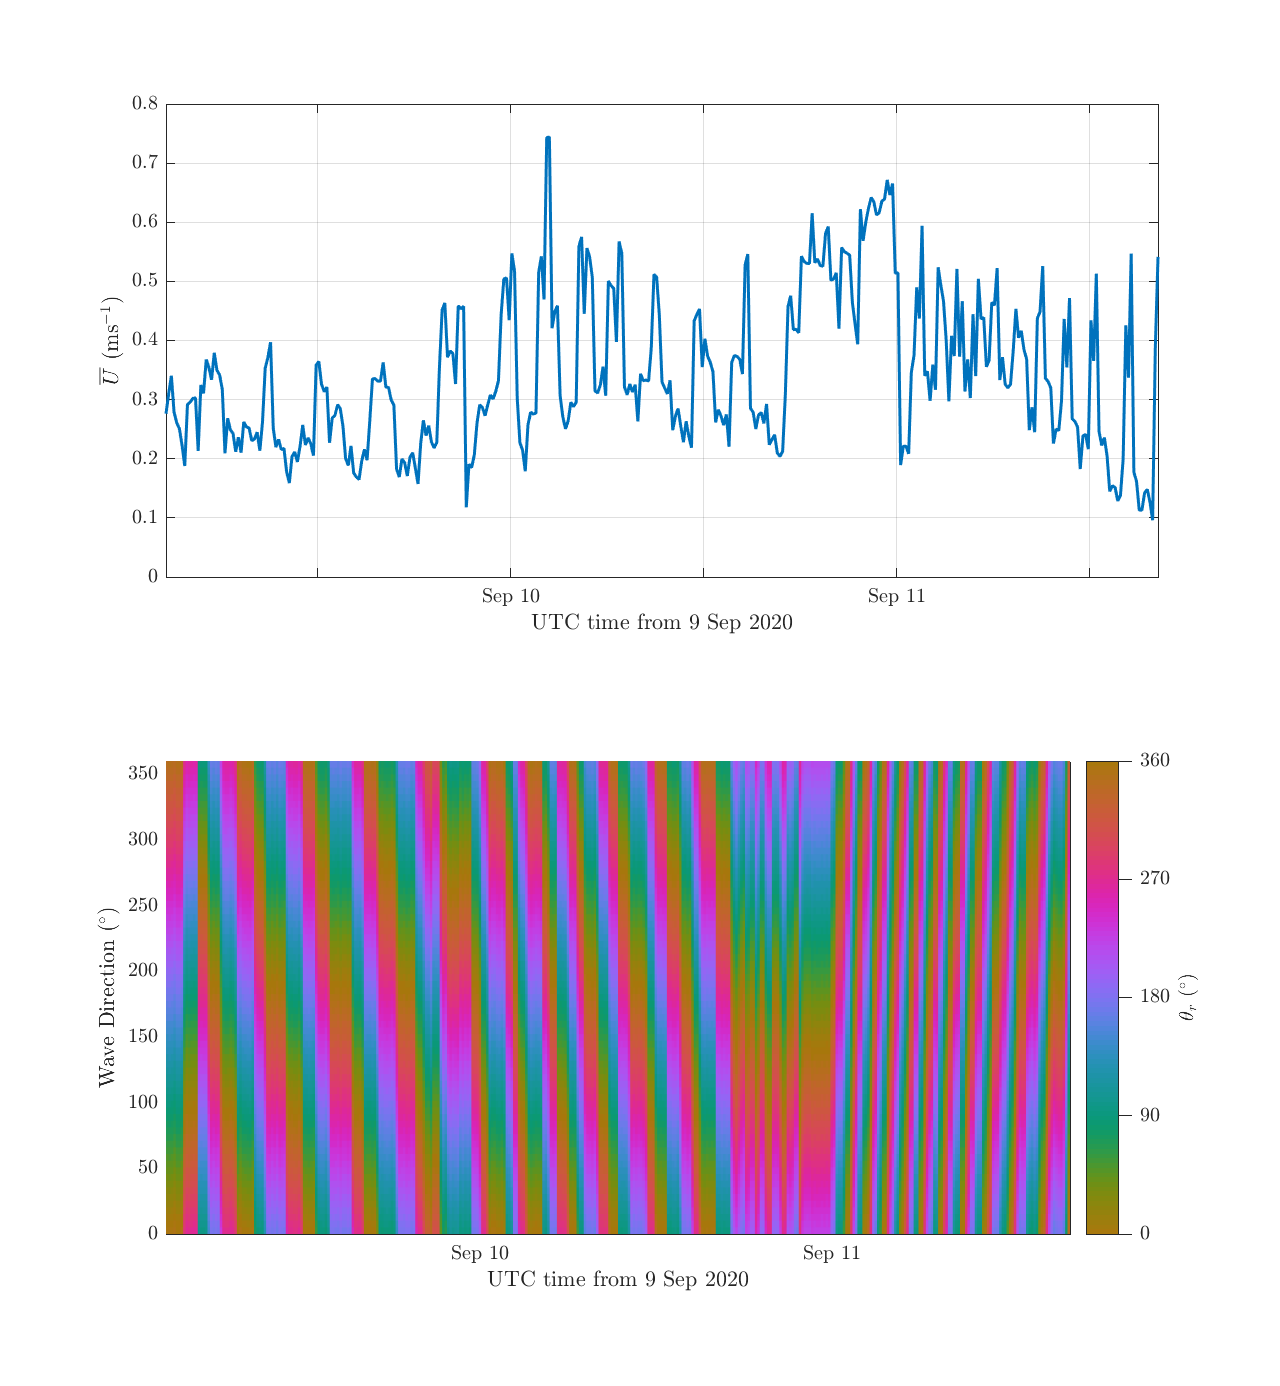

In [8]:
% Set plotting parameters
t_ticks = datetime('09-Sep-2020 00:00:00'):hours(12):datetime('12-Sep-2020 00:00:00');
fontsize = 10;
blue = [0 0.4470 0.7410];
theta = linspace(0,360,size(theta_r,1)); 

% Create figure
fig = figure('units','normalized','outerposition',[0 0 0.45 0.8]);

%------------ Subplot 1 ------------% 
ax1 = subplot(2,1,1);

% Plot time series of platform speed
plot(time, U_bar, '-', 'Color', blue, 'LineWidth', 1.5)

% Set figure attributes
xlabel('UTC time from 9 Sep 2020', 'Interpreter', 'latex')
ylabel('$\overline{U}$ (ms$^{-1}$)', 'Interpreter', 'latex')
xticks(datenum(t_ticks))
datetick('x', 'mmm dd', 'keepticks')
ax = gca;
labels = string(ax.XAxis.TickLabels);
labels(2:2:end) = ' ';
ax.XAxis.TickLabels = labels;
xlim([time(1), time(end)])
set(gca,'FontSize',fontsize)
set(gca,'TickLabelInterpreter','latex')
grid on 

%------------ Subplot 3 ------------% 
ax3 = subplot(2,1,2);

% Plot time series of platform speed
pcolor(time, theta, theta_r)

% Set figure attributes
shading flat
ylabel('Wave Direction ($^{\circ}$)', 'Interpreter', 'latex')
xlabel('UTC time from 9 Sep 2020', 'Interpreter', 'latex')
xticks(datenum(t_ticks))
datetick('x', 'mmm dd', 'keepticks')
ax = gca;
labels = string(ax.XAxis.TickLabels);
labels(2:2:end) = ' ';
ax.XAxis.TickLabels = labels;
xlim([time(1), time(end)])
set(gca,'FontSize',fontsize)
set(gca,'TickLabelInterpreter','latex')
grid on 

% Set colorbar attributes
cb = colorbar;
colormap(ax3, flipud(cmocean('phase', 100)))
cb.Label.Interpreter = 'Latex';
cb.Label.String = '$\theta_r$ ($^{\circ}$)';
caxis([0, 360]);
cb.Ticks = 0:90:360; 
cb.TickLabelInterpreter = 'latex';
cb.TickDirection = 'out';
cb.TickLength = 0.03;
cb.FontSize = fontsize;

These two quantities are used to compute the Doppler shift speed projected onto the wave direction $\theta_r$ 

$$ \tilde{c}_p = \bar{U}\cos(\theta_i - \bar{\phi}) .$$

Next, let's look at the first time step of `S_fob` and `S_fin` as well as the corresponding observed and intrinsic 1D spectra: 

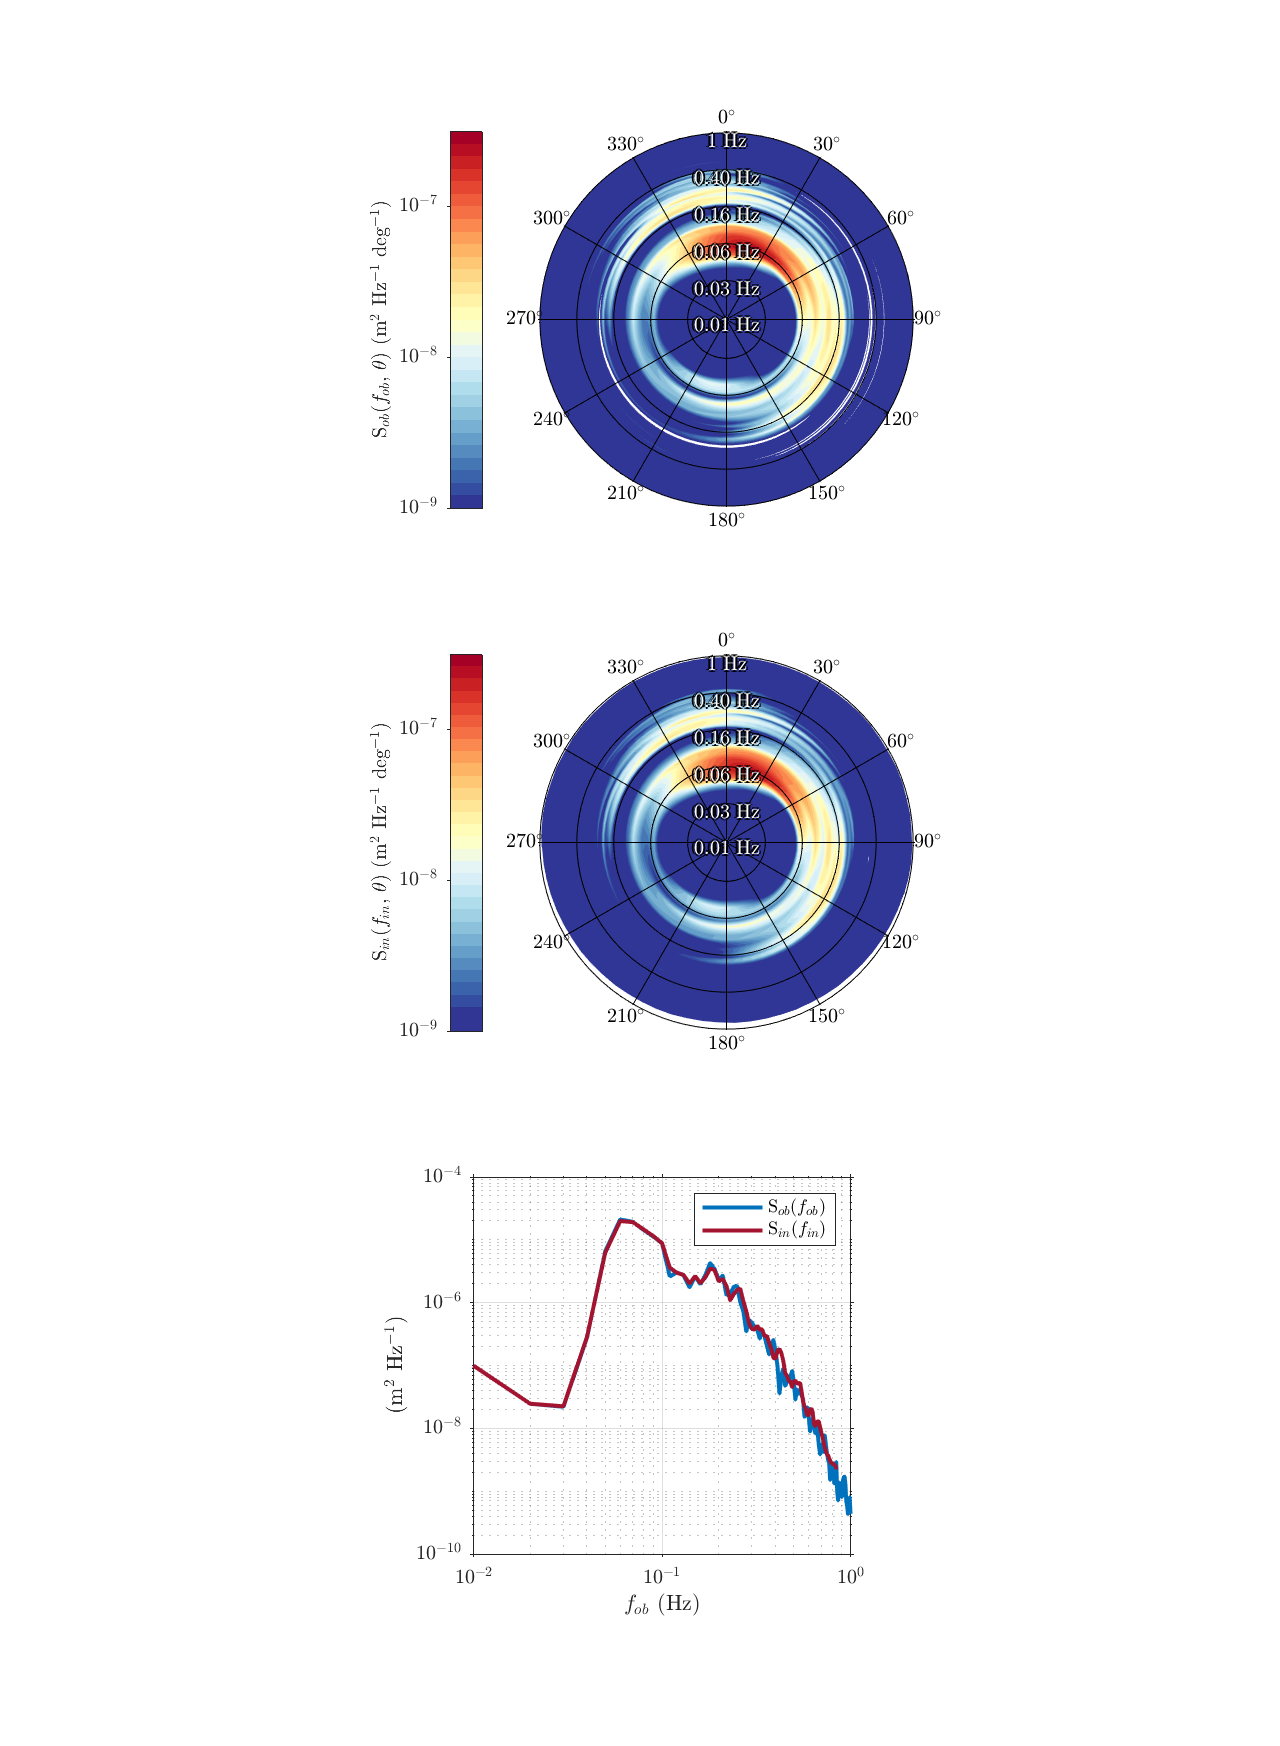

In [9]:
% Set plotting parameters
red = [0.6350 0.0780 0.1840];
Nspokes = 13; 
Ncircles = 6;
Rticks = {'0.01 Hz','0.03 Hz','0.06 Hz','0.16 Hz', '0.40 Hz', '1 Hz'};
Contours = logspace(-9,-6.5,30);
cb_ticks = [10^-9, 10^-8, 10^-7];
cb_ticklabels = {'10$^{-9}$'; '10$^{-8}$'; '10$^{-7}$'};
cb_label_ob = 'S$_{ob}$($f_{ob}$, $\theta$) (m$^2$ Hz$^{-1}$ deg$^{-1}$)';
cb_label_in = 'S$_{in}$($f_{in}$, $\theta$) (m$^2$ Hz$^{-1}$ deg$^{-1}$)';

% Create figure
fig = figure('units','normalized','outerposition',[0 0 0.45 1]);

%------------ Subplot 1 ------------% 
ax1 = subplot(3,1,1);

% Plot observed 2D wave spectrum 
plot_dir_spec(f_ob, theta, S_fob(:,:,1), Nspokes, Ncircles, Rticks, Contours, cb_ticks, cb_ticklabels, fontsize, cb_label_ob)

%------------ Subplot 2 ------------% 
ax2 = subplot(3,1,2);

% Plot intrinsic 2D wave spectrum 
plot_dir_spec(f_ob, theta, S_fin(:,:,1), Nspokes, Ncircles, Rticks, Contours, cb_ticks, cb_ticklabels, fontsize, cb_label_in)

%------------ Subplot 3 ------------% 
ax3 = subplot(3,1,3);

% Plot the observed 1D spectrum 
loglog(f_ob, S_fob_1d(:,1), '-', 'LineWidth', 2, 'Color', blue)

hold on 
    loglog(f_ob, S_fin_1d(:,1), '-', 'LineWidth', 2, 'Color', red)
hold off

% Set figure Attributes
ylabel('(m$^2$ Hz$^{-1}$)','Interpreter','Latex')
xlabel('$f_{ob}$ (Hz)','Interpreter','Latex')
xlim([10^-2 10^0])
ylim([10^-10 10^-4])
set(gca,'FontSize',fontsize)
set(gca,'TickDir','out');
set(gca,'TickLabelInterpreter','latex')
axis square
grid on 
set(gca,'Box','on') 
set(gca, 'color', 'w')
legend('S$_{ob}(f_{ob})$', 'S$_{in}(f_{in})$', 'location', 'NorthEast', 'Interpreter', 'latex')


Notice the cutoff frequencies in the figures above. Lastely, we can plot the 1D spectrograms: 

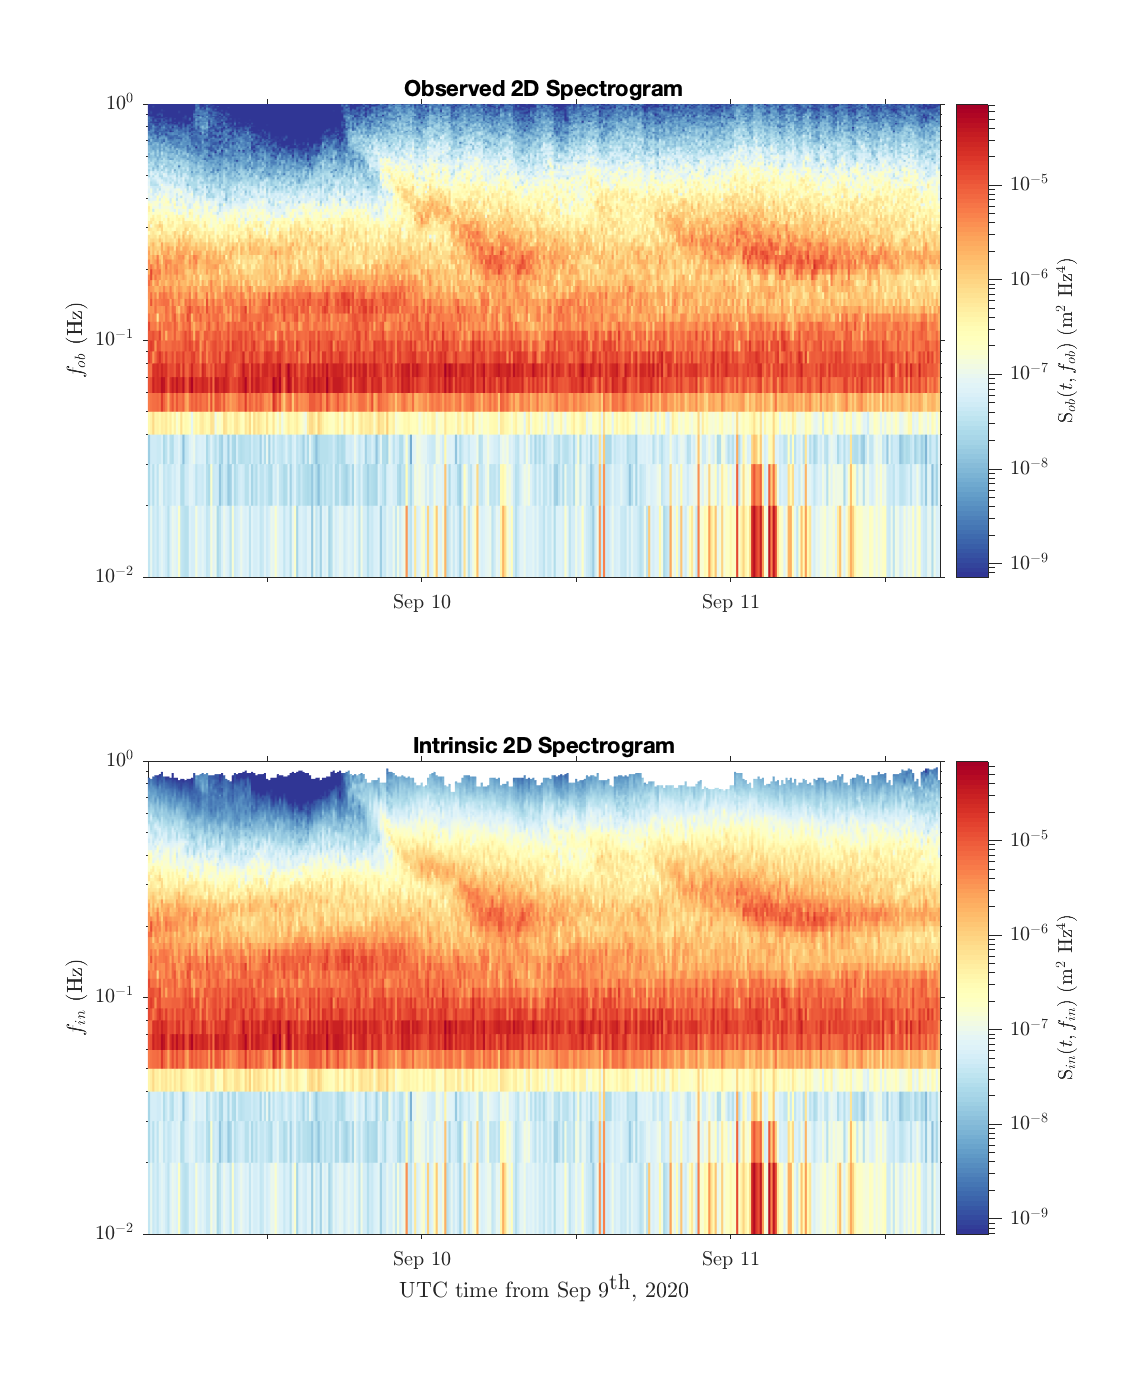

In [12]:
% Create figure
fig = figure('units','normalized','outerposition',[0 0 0.4 0.8]);

%------------ Subplot 1 ------------% 
ax1 = subplot(2,1,1);

% Plot observed saturation spectrogram from DELMAR2020
pc = pcolor(time, f_ob, S_fob_1d);

% Set figure attributes
t = title('Observed 2D Spectrogram');     
pc.EdgeColor = 'none';
ylabel('$f_{ob}$ (Hz)', 'Interpreter', 'latex')
set(gca,'Yscale','log')
set(gca,'TickDir','out');
set(gca, 'TickLength', [0.007, 0.007]) 
xticks(datenum(t_ticks))
datetick('x', 'mmm dd', 'keepticks')
ax = gca;
labels = string(ax.XAxis.TickLabels);
labels(2:2:end) = ' ';
ax.XAxis.TickLabels = labels;
xlim([time(2), time(end)])
set(gca,'FontSize',fontsize)
set(gca,'TickLabelInterpreter','latex')
set(gca,'Box','on')

% Set colorbar attributes
cb = colorbar;
colormap(flipud(cbrewer2('RdYlBu', 100)))
set(gca,'ColorScale','log')
cb.Label.Interpreter = 'Latex';
cb.Label.String = 'S$_{ob}$($t,f_{ob}$) (m$^2$ Hz$^{4}$)';  
cb.TickLabelInterpreter = 'latex';
cb.TickDirection = 'out';
cb.TickLength = 0.03;
cb.FontSize = fontsize;

%------------ Subplot 2 ------------% 
ax2 = subplot(2,1,2);

% Plot intrinsic frequency saturation spectrogram from DELMAR2020
pc = pcolor(time, f_ob, S_fin_1d);

% Set figure attributes
t = title('Intrinsic 2D Spectrogram');
pc.EdgeColor = 'none';
xlabel('UTC time from Sep 9$^{\textrm{th}}$, 2020', 'Interpreter', 'latex')
ylabel('$f_{in}$ (Hz)', 'Interpreter', 'latex')
set(gca,'Yscale','log')
set(gca,'TickDir','out');
set(gca, 'TickLength', [0.007, 0.007]) 
xticks(datenum(t_ticks))
datetick('x', 'mmm dd', 'keepticks')
ax = gca;
labels = string(ax.XAxis.TickLabels);
labels(2:2:end) = ' ';
ax.XAxis.TickLabels = labels;
xlim([time(2), time(end)])
set(gca,'FontSize',fontsize)
set(gca,'TickLabelInterpreter','latex')
set(gca,'Box','on')

% Set colorbar attributes
cb = colorbar;
colormap(flipud(cbrewer2('RdYlBu', 100)))
set(gca,'ColorScale','log')
cb.Label.Interpreter = 'Latex';
cb.Label.String = 'S$_{in}$($t,f_{in}$) (m$^2$ Hz$^{4}$)'; 
cb.TickLabelInterpreter = 'latex';
cb.TickDirection = 'out';
cb.TickLength = 0.03;
cb.FontSize = fontsize;
